# SARIMAX

## Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
Models like ARMA, ARIMA & SARIMA consider past values of a dataset and past errors to determine future trends, seasonality and forecasted values. SARIMAX encompass these non-seasonal (p,d,q) and seasonal (P,D,Q,m) factors, but introduce the idea that external factors (environmental, economic, etc.) can also influence a time series, and can be used in forecasting.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font><br>
<strong>
<a href='https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_stata.html'>Statsmodels Example:</a></strong>&nbsp;&nbsp;<font color=black>SARIMAX</font></div>

## Perform standard imports and load datasets

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

### Inspect the data
Restaurant Visitors dataset is inspired by a <a href='https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting'>recent Kaggle competition</a>. The data considers daily visitors to four restaurants located in the United States, subject to American holidays. For the exogenous variable we'll see how holidays affect patronage. The dataset contains 478 days of restaurant data, plus an additional 39 days of holiday data for forecasting purposes.

In [2]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


Notice that even though the restaurant visitor columns contain integer data, they appear as floats. This is because the bottom of the dataframe has 39 rows of NaN data to accommodate the extra holiday data we'll use for forecasting, and pandas won't allow NaN's as integers. We could leave it like this, but since we have to drop NaN values anyway, let's also convert the columns to dtype int64.

In [3]:
df.tail()      #date and holiday data of df will be used later to predict NaN in "total" column. 39 rows (refer cell 6) will be predicted.

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [4]:
len(df)

517

In [5]:
df1 = df.dropna()    #dropped the tail data (contains date and holiday info) which has NaN value. We will predict these data later.
df1.tail()           #df1 doesn't contain NaN but df still has NaN, date and holiday data which we will use later to predict NaN in "total" column.

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [6]:
len(df1)          #len(df1) - len(df) = 39

478

In [7]:
df.iloc[478]    #Notice that Date is 2017-04-23 from where NaN data has started and dropped row 478th to 516th

weekday         Sunday
holiday              0
holiday_name        na
rest1              NaN
rest2              NaN
rest3              NaN
rest4              NaN
total              NaN
Name: 2017-04-23 00:00:00, dtype: object

In [8]:
df.iloc[516]     #Notice that Date is 2017-05-31. Last line containing NaN data.

weekday         Wednesday
holiday                 0
holiday_name           na
rest1                 NaN
rest2                 NaN
rest3                 NaN
rest4                 NaN
total                 NaN
Name: 2017-05-31 00:00:00, dtype: object

In [9]:
# Change the dtype of selected columns to int from float
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


### Plot the source data

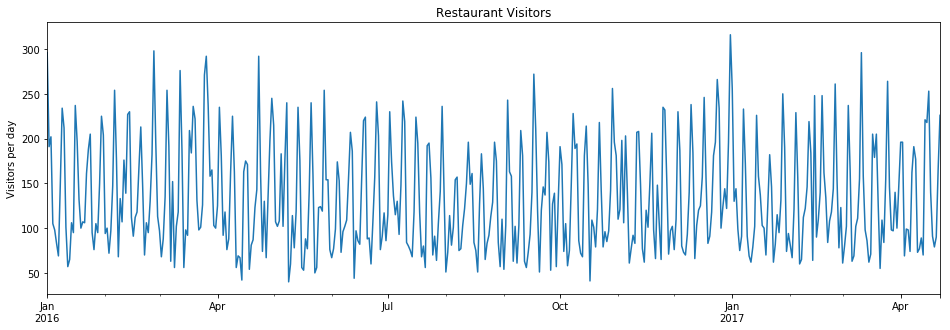

In [10]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Look at holidays
Rather than prepare a separate plot, we can use matplotlib to shade holidays behind our restaurant data.

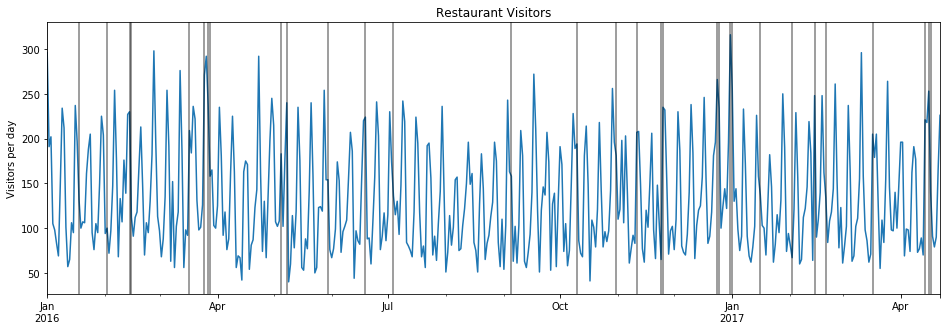

In [11]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1. It can be also used df1[df1['holiday']==1].index
    ax.axvline(x=x, color='k', alpha = 0.5);  # add a semi-transparent grey line. axvline is for axis vertical line.

### Run an ETS Decomposition

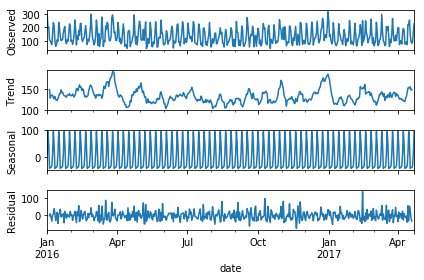

In [12]:
result = seasonal_decompose(df1['total'])
result.plot();

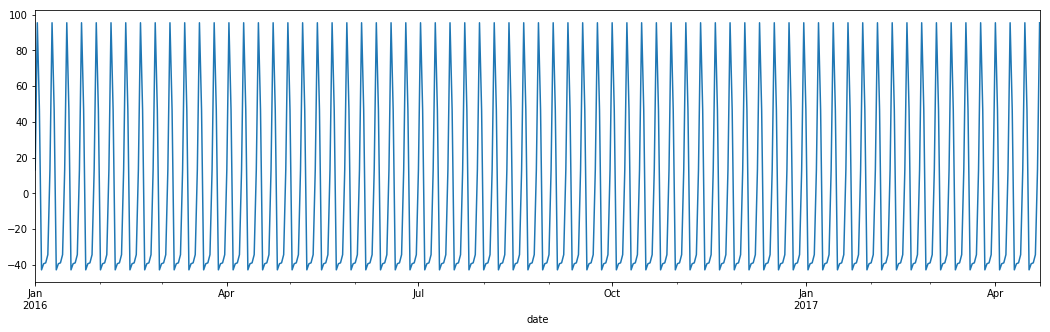

In [13]:
result.seasonal.plot(figsize=(18,5));

## Test for stationarity

In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [15]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot of combinations to evaluate.

In [16]:
# For SARIMA Orders we set seasonal=True and pass in an m value = 7 for weekly seasonal data
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2417.721
Date:                           Sun, 20 Oct 2019   AIC                           4845.442
Time:                                   00:22:09   BIC                           4866.290
Sample:                                        0   HQIC                          4853.638
                                           - 478                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.5657      4.363      4.714      0.000      12.014      29.117
ar.L1          0.1897      0.045      4.220      0.000       0.102       0.278
ar.S.L7        0.4258      0.037     11.606      0.000       0.354       0.498
ar.S.L14       0.3873      0.036     10.734      0.000       0.317       0.458
sigma2      1427.4032     86.679     16.468      0.000    1257.515    1597.292
===================================================================================
Ljung-Box (Q):                       77.20   Jarque-Bera (JB):                27.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.47
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This provides an ARIMA Order of (1,0,0) and a seasonal order of (2,0,0,7) Now let's train & test the SARIMA model, evaluate it, then compare the result to a model that uses an exogenous variable.
### Split the data into train/test sets
We'll assign 42 days (6 weeks) to the test set so that it includes several holidays.

In [17]:
len(df1)

478

In [18]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

### Fit a SARIMA(1,0,0)(2,0,0,7) Model
NOTE: To avoid a <tt>ValueError: non-invertible starting MA parameters found</tt> we're going to set <tt>enforce_invertibility</tt> to False.

In [19]:
model = SARIMAX(train['total'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2224.701
Date:                           Sun, 20 Oct 2019   AIC                           4457.403
Time:                                   00:22:09   BIC                           4473.713
Sample:                               01-01-2016   HQIC                          4463.840
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2212      0.047      4.711      0.000       0.129       0.313
ar.S.L7        0.5063      0.036     14.187      0.000       0.436       0.576
ar.S.L14       0.4574      0.037     12.379      0.000       0.385       0.530
sigma2      1520.2899     82.277     18.478      0.000    1359.029    1681.550
===================================================================================
Ljung-Box (Q):                       83.96   Jarque-Bera (JB):                29.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,0)(2,0,0,7) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

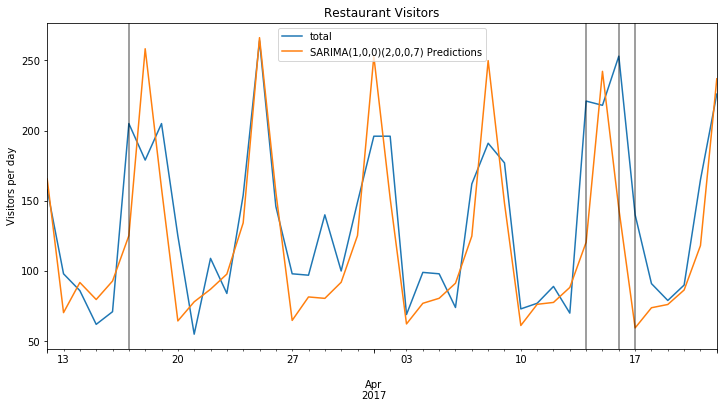

In [21]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.5);  #black line for holidays.

### Evaluate the Model

In [22]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647953
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315491


### Run pmdarima.auto_arima to obtain recommended orders during exogenous variable

In [23]:
# For SARIMA Orders we set seasonal=True and pass in an m value = 7 for weekly seasonal data
auto_arima(df1['total'], exogenous = df1[['holiday']] ,seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  478
Model:             SARIMAX(0, 0, 1)x(2, 0, 0, 7)   Log Likelihood               -2348.662
Date:                           Sun, 20 Oct 2019   AIC                           4709.323
Time:                                   00:22:35   BIC                           4734.341
Sample:                                        0   HQIC                          4719.159
                                           - 478                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.5555      4.274      2.704      0.007       3.180      19.931
x1            74.8356      4.545     16.464      0.000      65.927      83.744
ma.L1          0.1782      0.051      3.474      0.001       0.078       0.279
ar.S.L7        0.5059      0.045     11.232      0.000       0.418       0.594
ar.S.L14       0.3843      0.043      8.982      0.000       0.300       0.468
sigma2      1142.0212     80.192     14.241      0.000     984.849    1299.194
===================================================================================
Ljung-Box (Q):                       85.07   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.00   Prob(JB):                         0.41
Heteroskedasticity (H):               0.89   Skew:                             0.12
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Now add the exog variable

In [24]:
#From autoarima above, SARIMAX(0, 0, 1)(2, 0, 0, 7)
model = SARIMAX(train['total'],exog=train['holiday'],order=(0,0,1),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(0, 0, 1)x(2, 0, 0, 7)   Log Likelihood               -2158.891
Date:                           Sun, 20 Oct 2019   AIC                           4327.783
Time:                                   00:22:37   BIC                           4348.171
Sample:                               01-01-2016   HQIC                          4335.829
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       67.9539      4.278     15.886      0.000      59.570      76.338
ma.L1          0.2057      0.050      4.117      0.000       0.108       0.304
ar.S.L7        0.5146      0.042     12.369      0.000       0.433       0.596
ar.S.L14       0.4598      0.041     11.135      0.000       0.379       0.541
sigma2      1118.0445     73.447     15.223      0.000     974.092    1261.997
===================================================================================
Ljung-Box (Q):                      101.65   Jarque-Bera (JB):                 1.29
Prob(Q):                              0.00   Prob(JB):                         0.52
Heteroskedasticity (H):               0.90   Skew:                             0.11
Prob(H) (two-sided):                  0.54   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(0,0,1)(2,0,0,7) Predictions')

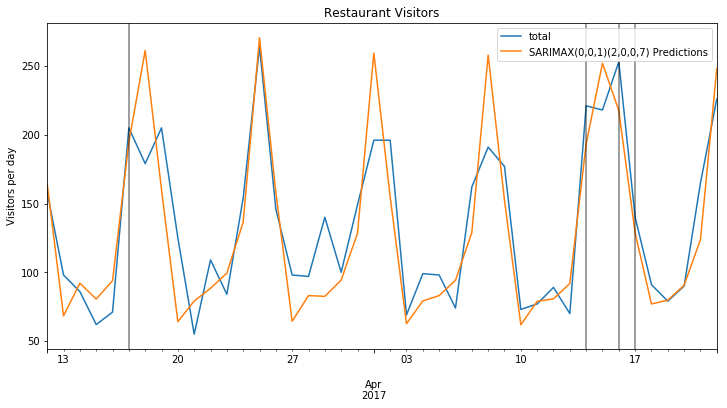

In [26]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.5);

We can see that the exogenous variable (holidays) had a positive impact on the forecast by raising predicted values at holiday (dark lines) 3/17, 4/14, 4/16 and 4/17! Let's compare evaluations:
### Evaluate the Model

In [27]:
# Print values from SARIMA above
print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(2,0,0,7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(2,0,0,7) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647953
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315491

SARIMAX(1,0,0)(2,0,0,7) MSE Error: 966.7480049
SARIMAX(1,0,0)(2,0,0,7) RMSE Error: 31.09257154


### Retrain the model on the full data, and forecast the future
We're going to forecast 39 days (refer cell 6) into the future, and use the additional holiday data ie. you have to know/keep the holiday data for 39 days into the future. 

In [28]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(0,0,1),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]    #refer cell 5, 6, 7 of this notebook.
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(0,0,1)(2,0,0,7) Forecast')

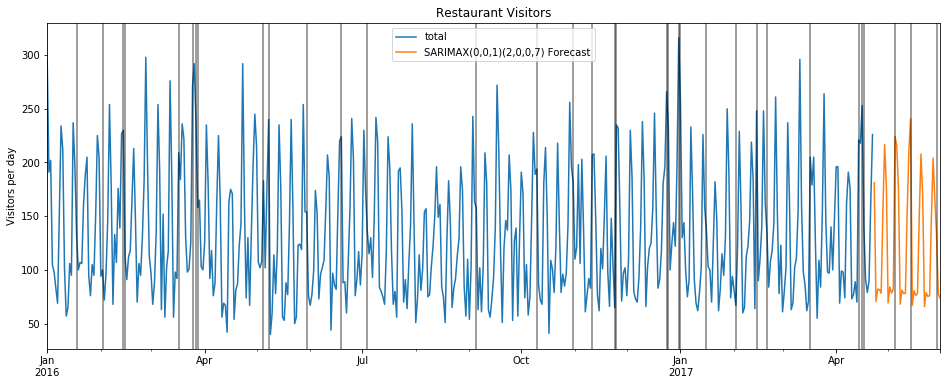

In [29]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.5);

In [30]:
fcast      #refer cell 7 and 8 of this notebook

2017-04-23    181.017369
2017-04-24     70.501784
2017-04-25     82.131017
2017-04-26     81.752564
2017-04-27     78.325142
2017-04-28    155.066041
2017-04-29    216.603248
2017-04-30    178.225410
2017-05-01     69.287099
2017-05-02     84.272083
2017-05-03     78.420090
2017-05-04     81.884680
2017-05-05    224.250306
2017-05-06    215.647918
2017-05-07    175.108753
2017-05-08     68.136457
2017-05-09     81.165429
2017-05-10     78.041395
2017-05-11     78.168196
2017-05-12    151.625597
2017-05-13    210.733759
2017-05-14    240.578048
2017-05-15     66.984226
2017-05-16     80.611895
2017-05-17     76.278551
2017-05-18     77.976940
2017-05-19    149.867773
2017-05-20    207.809598
2017-05-21    169.299832
2017-05-22     65.861410
2017-05-23     78.867590
2017-05-24     75.212593
2017-05-25     76.127267
2017-05-26    146.968699
2017-05-27    204.019319
2017-05-28    166.467044
2017-05-29    133.107875
2017-05-30     77.728476
2017-05-31     73.844369
Freq: D, Name: SARIMAX(0,

In [31]:
fcast.tail()    #Compare it with cell 3 of this notebook. 39 rows of data is predicted. 

2017-05-27    204.019319
2017-05-28    166.467044
2017-05-29    133.107875
2017-05-30     77.728476
2017-05-31     73.844369
Freq: D, Name: SARIMAX(0,0,1)(2,0,0,7) Forecast, dtype: float64